The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic, bin_occurrences
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

In [2]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [3]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [40]:
def load_exp_data(direc, cut=None, layer_size=20, row_min=0, row_max=None, col_min=0, col_max=None):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    if cut is not None:
        file_names = file_names[:cut]
    
    for i_f in range(0, len(file_names)):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        w_r_e = loaded['w_r_e']
        
        if row_max is None:
            row_max = w_r_e.shape[0]
        if col_max is None:
            col_max = w_r_e.shape[1]
        
        target_w_r_e = w_r_e[row_min:row_max, col_min:col_max]
        summed_incoming_weights = target_w_r_e.sum(axis=1)
        
        try:
            exc_cells_initially_active = loaded['exc_raster']
            exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] / 0.2e-3  
            
            exc_cells_newly_active = None
        except KeyError as e:
            exc_cells_initially_active = loaded['exc_cells_initially_active']
            exc_cells_newly_active = loaded['exc_cells_newly_active']
        inh_raster = loaded['inh_raster']
        
        try:
            surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
        except KeyError as e:
            surviving_cell_indices = np.ones(row_max, dtype=bool)
        
        first_spk_times = process_single_activation(exc_cells_initially_active, 900)
        
        last_layer_active = 0
        layer_weights = []
        
        for i in range(0, len(first_spk_times), layer_size):
            layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
            if layer_active:
                last_layer_active = i/layer_size
        
            layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
            layer_weights.append(layer_weight)
            
        data = {
            'index': i_f,
            'last_layer_active': last_layer_active,
            'first_spk_times': first_spk_times,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
            'summed_incoming_weights': summed_incoming_weights,
            'exc_cells_initially_active': exc_cells_initially_active,
            'exc_cells_newly_active': exc_cells_newly_active,
            'inh_raster': inh_raster,
            'freqs': loaded['freqs'][0],
            'spk_bins': loaded['spk_bins'][0],
            'surviving_cell_indices': surviving_cell_indices,
        }
        yield i_f, data

### Figure 1: rasters of the chain pre-perturbation, directly post-perturbation, and recovered (with all plasticity rules in effect)

In [41]:
def make_figure_1(name):
    scale = 1.1
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15 * scale, 4 * scale))
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        timepoints = [99, 103, 122, 500]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 row_min=0, row_max=900, col_min=0, col_max=900):
            
            if j < len(timepoints) and i == timepoints[j]:
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 0.2e-3 * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.2)
                    if len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 0.2e-3 * 1000, exc_cells_newly_active[1, :], s=1, c='green', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='red', zorder=0, alpha=1)
                axs[j].set_ylim(200, 1350)
                axs[j].set_xlim(.01 * 1000, 0.06 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                j += 1
    
    fig.tight_layout()
        

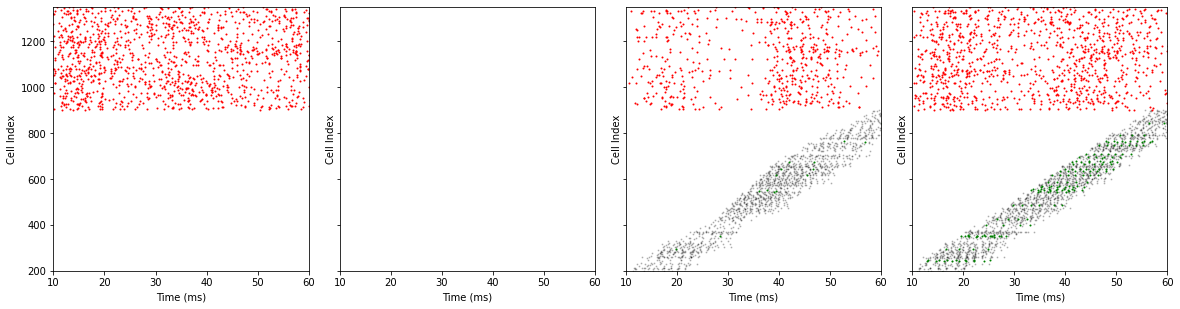

In [42]:
make_figure_1('all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219')

### Figure 2: comparisons of the summed synaptic strengths per HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

In [8]:
def make_figure_2_median(names, ylim=(0, 4)):
    scale = 1.1
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8 * scale, 4 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):
        all_median_incoming_summed_weights = []
        baseline_median = None
        cap=600
        
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]),
                                 row_min=0, row_max=900, col_min=0, col_max=900):
            if i < cap:
                all_median_incoming_summed_weights.append(np.median(data['summed_incoming_weights']))
                
            if i == 0:
                baseline_median = np.median(data['summed_incoming_weights'])
                
        all_median_incoming_summed_weights = np.array(all_median_incoming_summed_weights) / baseline_median
        
        axs.plot(np.arange(cap), all_median_incoming_summed_weights, lw=0.7, color=spaced_colors[idx], label=labels[idx])
        axs.set_xlim(0, cap)
        axs.set_ylim(ylim[0], ylim[1])
        axs.set_xlabel('Network activations')
        axs.set_ylabel('Median summed synapse strength\n onto excitatory cells')
        axs.legend()
    
    fig.tight_layout()


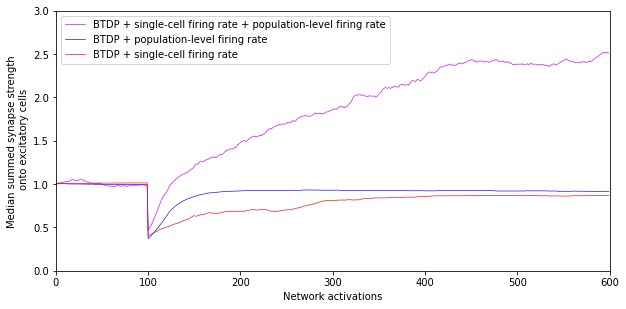

In [21]:
make_figure_2_median([
    'all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219',
    'pop_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--23:3219',
    'single_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--34:3219',
], ylim=(0, 3))

In [10]:
def make_figure_2(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8 * scale, 4 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):
        all_mean_incoming_summed_weights = []
        all_std_incoming_summed_weights = []
        baseline_mean = None
        baseline_std = None
        cap=600
        
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]),
                                 row_min=0, row_max=900, col_min=0, col_max=900):
            if i < cap:
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                
            if i == 0:
                baseline_mean = data['mean_incoming_summed_weights']
                baseline_std = data['std_incoming_summed_weights']
        all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
        all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
        
        axs.fill_between(np.arange(cap), all_mean_incoming_summed_weights - all_std_incoming_summed_weights, all_mean_incoming_summed_weights + all_std_incoming_summed_weights,
                         alpha=0.1, color=spaced_colors[idx], zorder=-idx)
        axs.plot(np.arange(cap), all_mean_incoming_summed_weights, lw=0.7, color=spaced_colors[idx], label=labels[idx])
        axs.set_xlim(0, cap)
        axs.set_ylim(ylim[0], ylim[1])
        axs.set_xlabel('Network activations')
        axs.set_ylabel('Normalized \n<summed synapse strength onto excitatory cells>')
        axs.legend()
        
    
    fig.tight_layout()


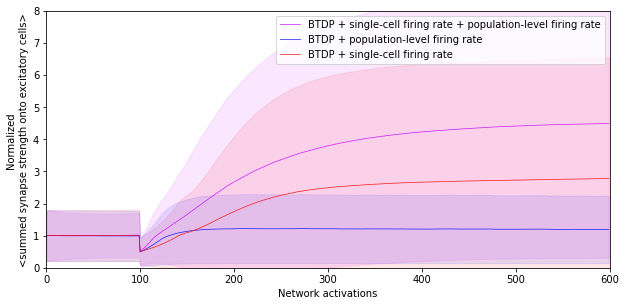

In [11]:
make_figure_2([
    'all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219',
    'pop_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--23:3219',
    'single_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--34:3219',
])

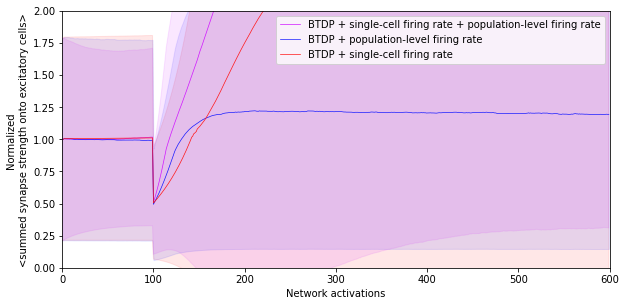

In [12]:
make_figure_2([
    'all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219',
    'pop_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--23:3219',
    'single_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--34:3219',
], ylim=(0, 2))

In [13]:
def make_figure_2_alt(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(3, 1, sharex=False, sharey=True, figsize=(8 * scale, 10 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    step = 50
    cap=600
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):
        all_incoming_summed_weights = []
        
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]),
                                 row_min=0, row_max=900, col_min=0, col_max=900):
            if i % step != 0:
                continue
            if i >= cap:
                break
            all_incoming_summed_weights.append(data['summed_incoming_weights'])
        
        x = np.arange(0, cap, step)
        parts = axs[idx].violinplot(all_incoming_summed_weights, x, widths=np.ones(len(x)) * step * 0.5,
                      showmedians=True)
        
        axs[idx].set_xlim(-0.5 * step, cap)
        axs[idx].set_ylim(ylim[0], ylim[1])
        if idx == len(all_dirs) - 1:
            axs[idx].set_xlabel('Network activations')
        axs[idx].set_ylabel('Summed synapse strength\n onto excitatory cells')
#         axs.legend()

        for pc in parts['bodies']:
            pc.set_facecolor(spaced_colors[idx])
            pc.set_edgecolor(spaced_colors[idx])
            pc.set_alpha(0.5)
        
        for part_type in ['cmaxes', 'cmins', 'cbars', 'cmedians']:
            parts[part_type].set_color('black')
            
        
    fig.tight_layout()

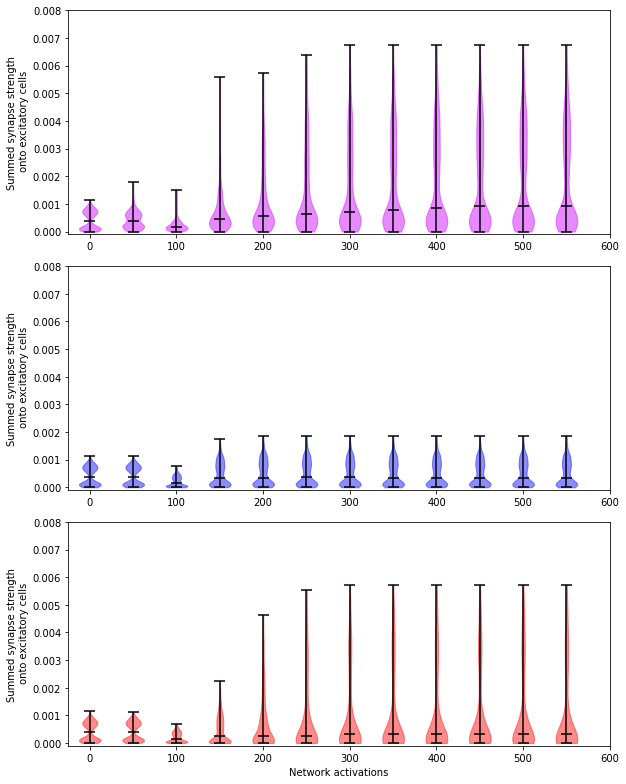

In [14]:
make_figure_2_alt([
    'all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219',
    'pop_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--23:3219',
    'single_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--34:3219',
], ylim=(-0.0001, 0.008))

### Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

In [15]:
def make_figure_3(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(6 * scale, 8 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#1f22ff', 'black', '#ff1f71']
    labels = [
        'unperturbed',
        'perturbed',
        '500th rendition',
    ]
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):
        timepoints = [99, 103, 600]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]),
                                 row_min=0, row_max=900, col_min=0, col_max=900):
            if j < len(timepoints) and i == timepoints[j]:                
                spk_bins = data['spk_bins']
                freqs = data['freqs']
                if idx == 0:
                    axs[idx].bar(spk_bins, freqs, color=spaced_colors[j], alpha=0.3, zorder=-j, width=1, label=labels[j])
                else:
                    axs[idx].bar(spk_bins, freqs, color=spaced_colors[j], alpha=0.3, zorder=-j, width=1)
                
                j += 1

        axs[idx].set_ylabel('Frequency')
        if idx == (len(all_dirs) - 1):
            axs[idx].set_xlabel('Spks per neuron')
        axs[idx].set_xlim(-0.5, 20.5)
        axs[idx].set_ylim(0, 450)
        if idx == 0:
            axs[0].legend()
            
    
    fig.tight_layout()

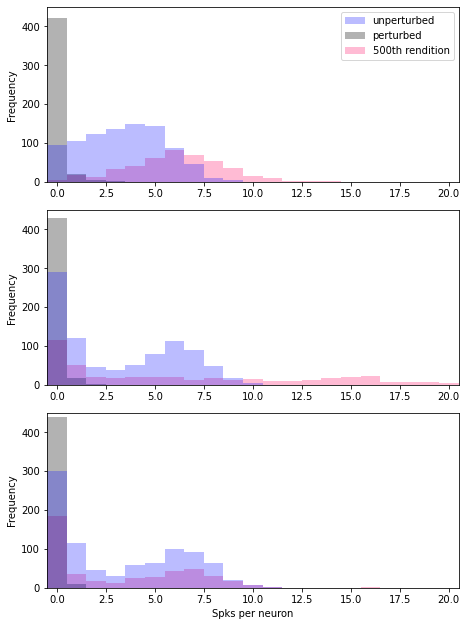

In [16]:
make_figure_3([
    'all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219',
    'pop_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--23:3219',
    'single_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--34:3219',
])

(1) BTDP + single-cell firing rate upper bound + popopulation-level firing rate

(2) BTDP + population-level firing rate

(3) BTDP + single-cell rule (NOTE: single cell setpoints were artificial & silent cells were drawn in early)

In [35]:
def make_figure_4(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(8 * scale, 8 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(20) * i for i in range(0, 900, 20)])
    cap = 600
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    for idx, exp_dir_name in enumerate(sorted(all_dirs)):   
        pop_firing_rates = []
        relative_prop_speeds = []
        r_squareds = []
        last_layer_actives = []
    
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]),
                                 row_min=0, row_max=900, col_min=0, col_max=900):
            if i == cap:
                break
            
            pop_firing_rate = np.sum(data['exc_cells_initially_active'])
            if data['exc_cells_newly_active'] is not None:
                pop_firing_rate += np.sum(data['exc_cells_newly_active'])
            pop_firing_rates.append(pop_firing_rate)
            
            first_spk_times = data['first_spk_times']
            filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))
            
            x_firing = x[filtered_indices]
            first_spk_times_nonnan = first_spk_times[filtered_indices]
            
            res = stats.linregress(x_firing, first_spk_times_nonnan)
            relative_prop_speeds.append(res.slope)
            r_squareds.append(np.square(res.rvalue))
            last_layer_actives.append(data['last_layer_active'])
            
        epochs = np.arange(cap)
        axs[0].scatter(epochs, pop_firing_rates, c=spaced_colors[idx], s=1)
        axs[1].scatter(epochs, relative_prop_speeds, c=spaced_colors[idx], label=labels[idx], s=1)
        axs[2].scatter(epochs, r_squareds,c=spaced_colors[idx], s=1)
        axs[3].scatter(epochs, last_layer_actives, c=spaced_colors[idx], s=1)
        
        axs[0].set_ylabel('Population spks\nper activation')
        axs[1].set_ylabel('Propagation speed')
        axs[2].set_ylabel(r'$R^2$')
        axs[3].set_ylabel('Last layer active')
        axs[3].set_xlabel('Epochs')
        
        axs[1].set_ylim(0, .4)
        axs[3].set_ylim(0, 45)
        
        for i in range(4):
            axs[i].set_xlim(0, cap)
            
        axs[1].legend()
    
    fig.tight_layout()

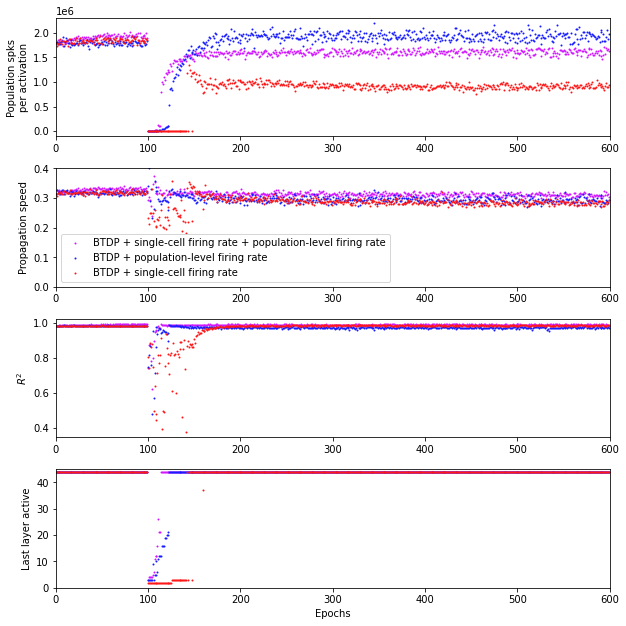

In [36]:
make_figure_4([
    'all_rules_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:06--45:3219',
    'pop_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--23:3219',
    'single_btdp_ff_1.0_pf_0.7_pr_0.0_eir_2.5_ier_0.3_2021-05-07--00:09--34:3219',
])